# Library

In [1]:
import cv2
import numpy as np
from scipy.fft import fftshift, fft2, ifft2
import matplotlib.pyplot as plt

# Load Images

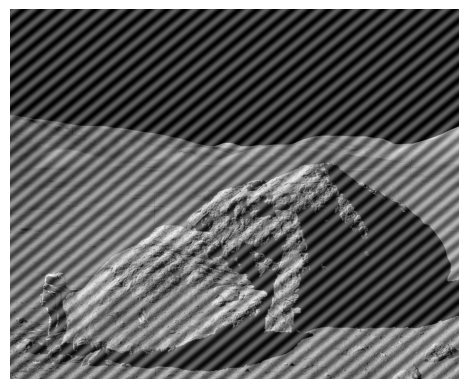

In [2]:
img1 = cv2.imread('astronaut-interference.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.show()

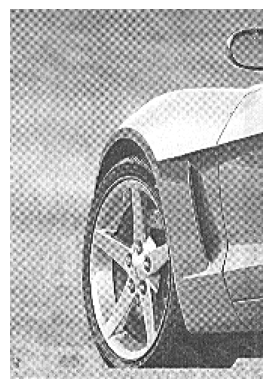

In [3]:
img2 = cv2.imread('car-moire-pattern.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.show()

# Useful Functions

In [66]:
def noise_canceling(image, D0=9, n=4, notch_centers=[(0, 0)], padding=None, figsize=(10, 10)):
    # Padding
    padded_image = image.copy()
    if padding == "zero":
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], cv2.BORDER_CONSTANT, value=0)
    if padding == "wrap":
        padded_image = cv2.copyMakeBorder(padded_image, 0, image.shape[0], 0, image.shape[1], cv2.BORDER_WRAP)
    
    # FFT
    dft = fft2(padded_image)
    dft_shifted = fftshift(dft)  # Shift the zero frequency component to the center
    magnitude_spectrum = np.log(1 + np.abs(dft_shifted))
    
    # Butterworth Notch Filter
    def butterworth_notch_reject_filter(shape, D0, n, centers):
        rows, cols = shape
        u = np.arange(rows)
        v = np.arange(cols)
        u, v = np.meshgrid(u - rows // 2, v - cols // 2, sparse=False, indexing='ij')
        
        # Initialize filter
        filter_mask = np.ones((rows, cols), dtype=np.float32)
        
        for center in centers:
            D = np.sqrt((u - center[0])**2 + (v - center[1])**2)
            filter_mask *= 1 / (1 + (D0 / D)**n)
            
            D_conj = np.sqrt((u + center[0])**2 + (v + center[1])**2)
            filter_mask *= 1 / (1 + (D0 / D_conj)**n)
        
        return filter_mask

    # Create the notch filter mask
    notch_filter = butterworth_notch_reject_filter(dft_shifted.shape, D0, n, notch_centers)

    # Apply the filter in the frequency domain
    filtered_dft = dft_shifted * notch_filter
    filtered_magnitude_spectrum = np.log(1 + np.abs(filtered_dft))
    
    # IFFT
    inverse_shifted = np.fft.ifftshift(filtered_dft)
    img_filtered = np.abs(ifft2(inverse_shifted))
    
    # Crop to original image size
    if padding != None:
        original_height, original_width = image.shape
        start_row, start_col = -padded_image.shape[0], 0
        img_filtered = img_filtered[start_row:start_row + original_height, start_col:start_col + original_width]
    
    # Plotting results
    plt.figure(figsize=figsize)
    plt.subplot(2, 2, 1), plt.imshow(image, cmap='gray')
    plt.title('Original Image'), plt.axis('off')
    plt.subplot(2, 2, 2), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Fourier Spectrum'), plt.axis('off')
    plt.subplot(2, 2, 3), plt.imshow(filtered_magnitude_spectrum, cmap='gray')
    plt.title('Filtered Spectrum'), plt.axis('off')
    plt.subplot(2, 2, 4), plt.imshow(img_filtered, cmap='gray')
    plt.title('Filtered Image'), plt.axis('off')
    plt.show()

### 1. astronaut-interference.tif

C:\Users\vince\AppData\Local\Temp\ipykernel_77188\3692755743.py:26: RuntimeWarning: divide by zero encountered in divide
  filter_mask *= 1 / (1 + (D0 / D)**n)
C:\Users\vince\AppData\Local\Temp\ipykernel_77188\3692755743.py:29: RuntimeWarning: divide by zero encountered in divide
  filter_mask *= 1 / (1 + (D0 / D_conj)**n)


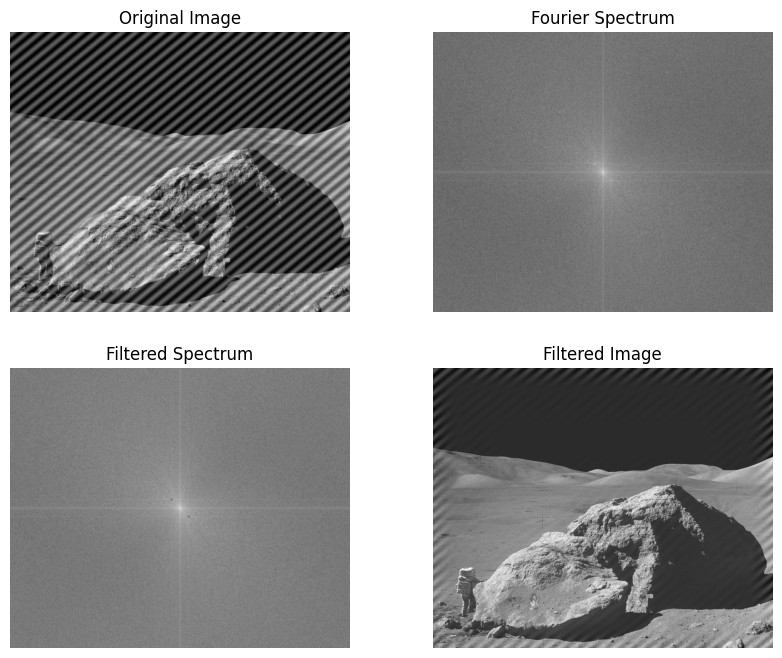

In [67]:
noise_canceling(img1, notch_centers=[(50, 50)], padding="zero", figsize=(10, 8))

### 2. car-moire-pattern.tif

C:\Users\vince\AppData\Local\Temp\ipykernel_77188\3692755743.py:26: RuntimeWarning: divide by zero encountered in divide
  filter_mask *= 1 / (1 + (D0 / D)**n)
C:\Users\vince\AppData\Local\Temp\ipykernel_77188\3692755743.py:29: RuntimeWarning: divide by zero encountered in divide
  filter_mask *= 1 / (1 + (D0 / D_conj)**n)


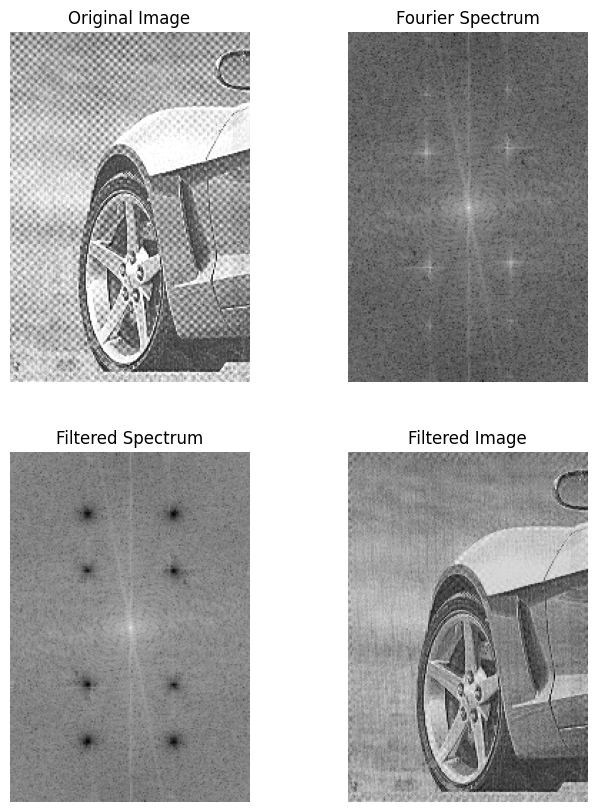

In [68]:
noise_canceling(img2, notch_centers=[(40, 30), (-40, 30), (80, 30), (-80, 30)], figsize=(8, 10))